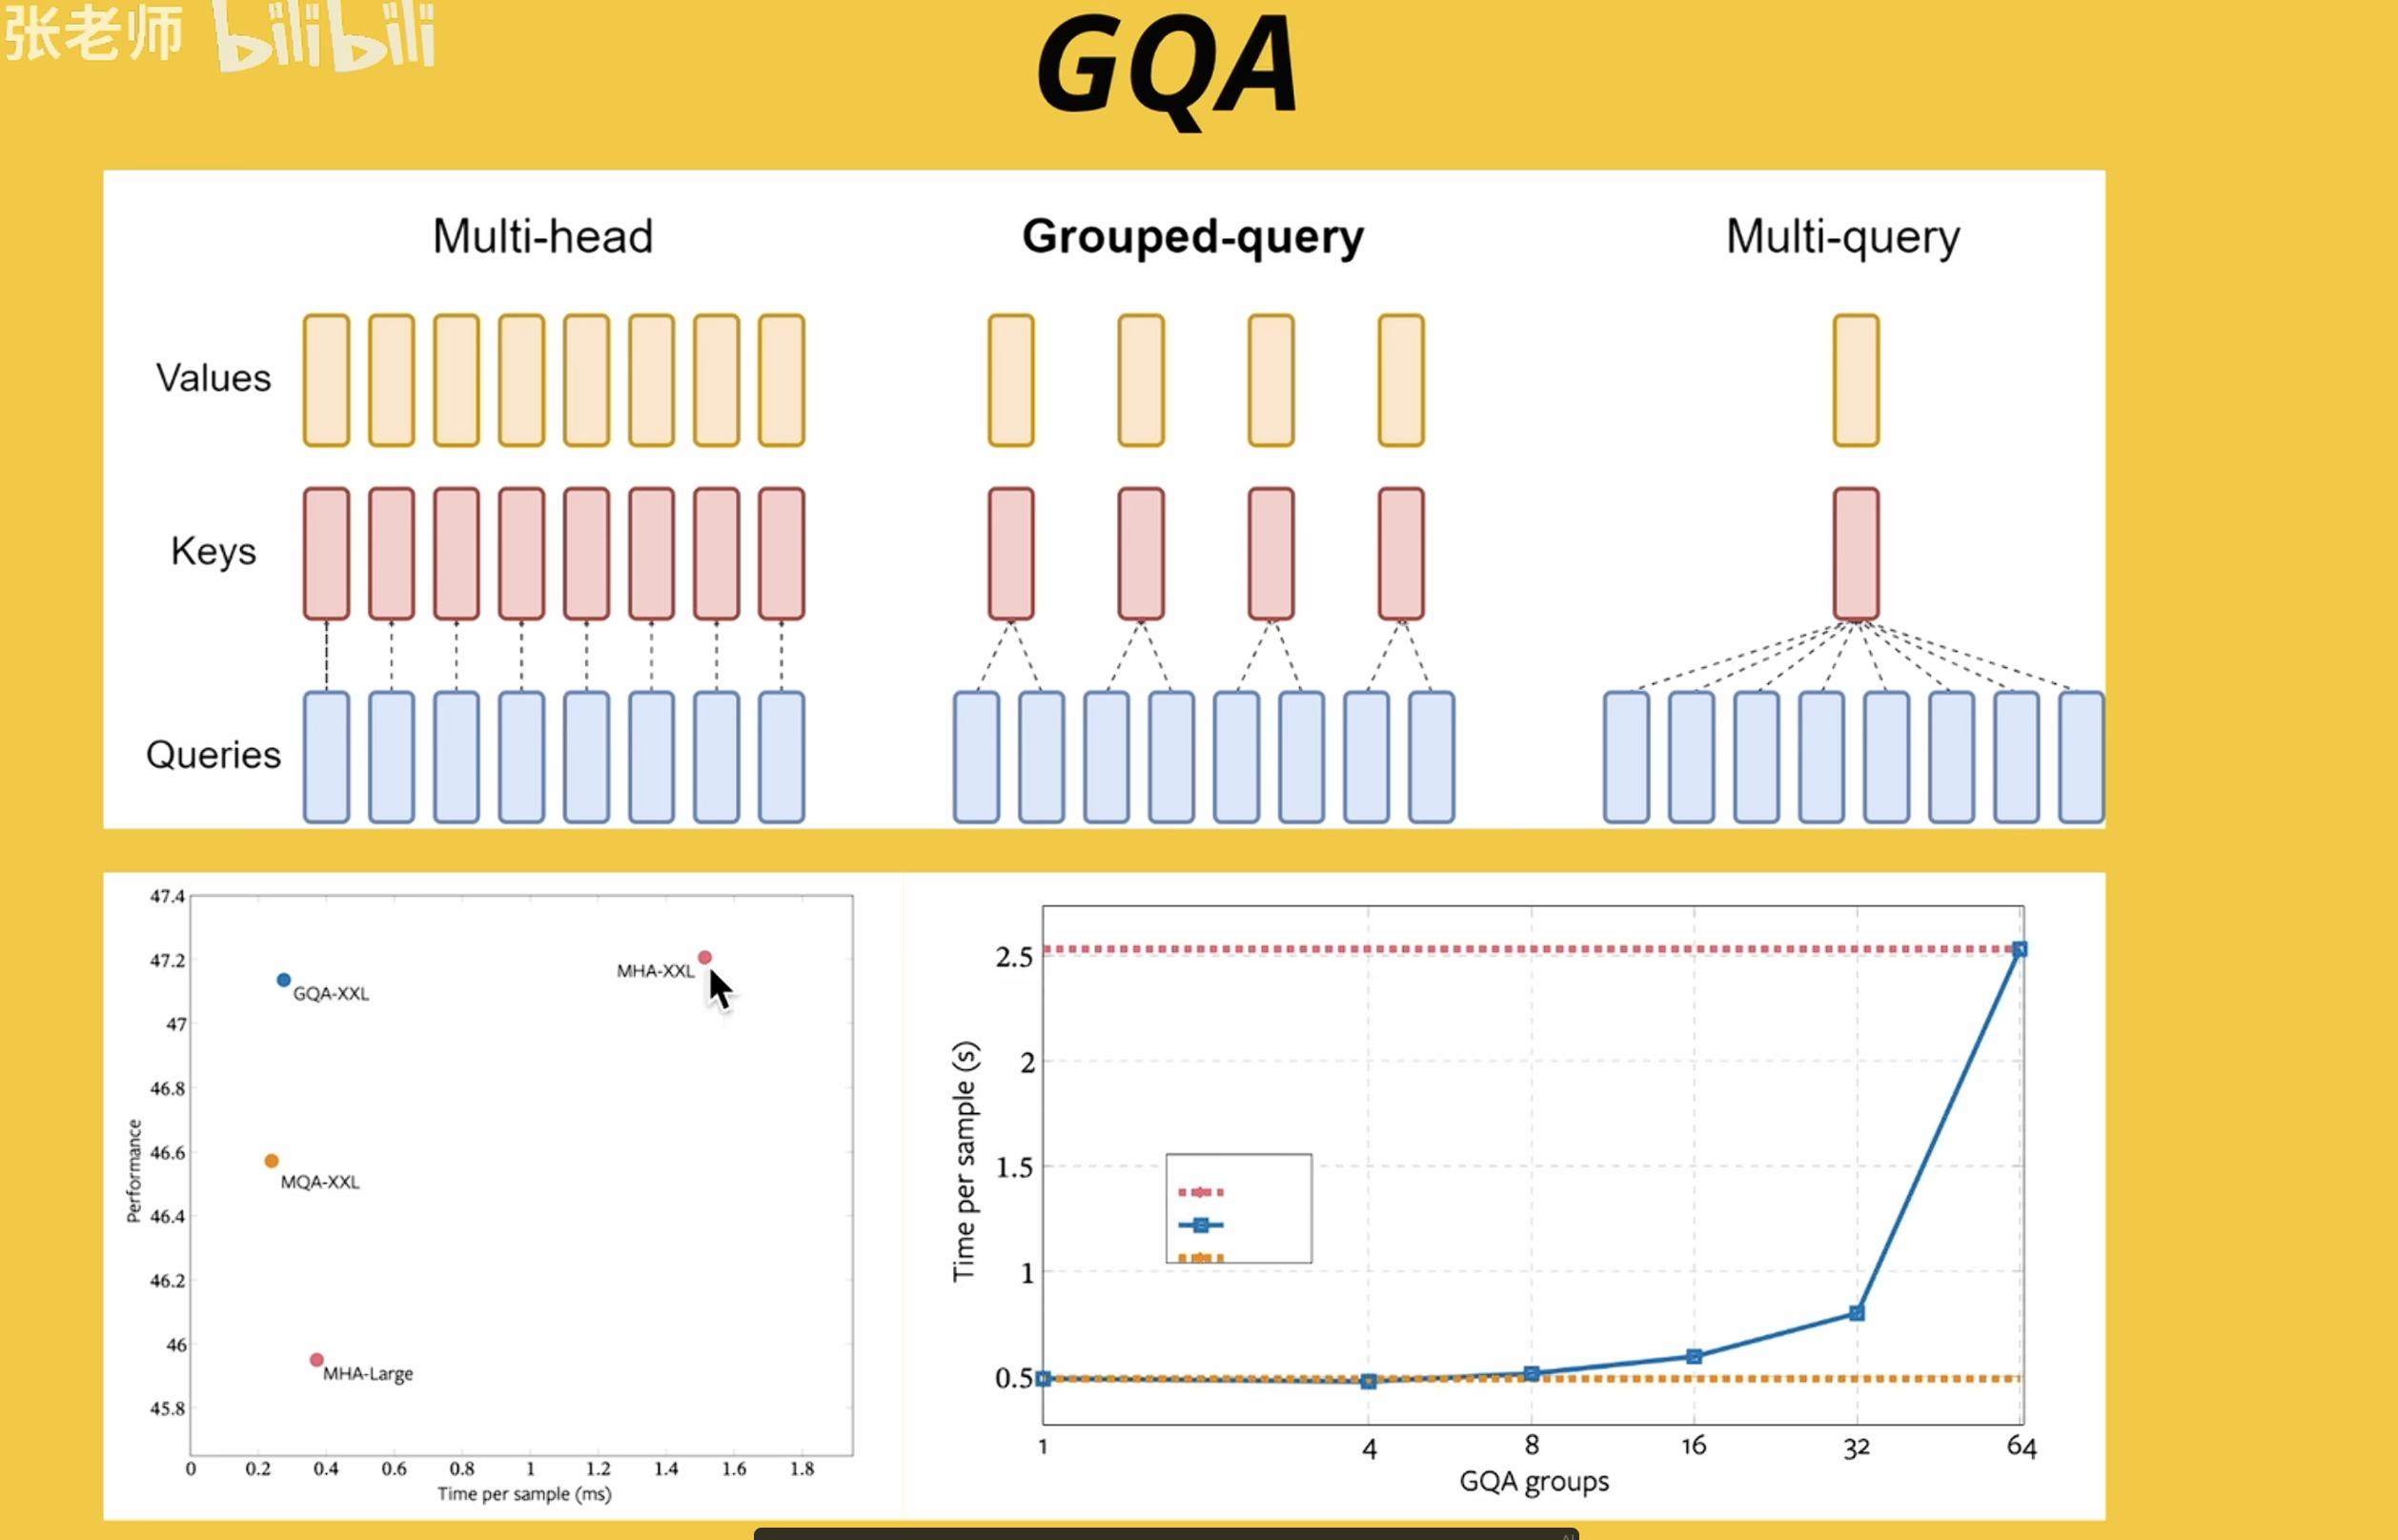

**GQA**

In [8]:
import torch
import torch.nn.functional as F
batch_size = 1
seq_len = 1024
d_model = 4096
# 注意力头数
num_heads_q = 32
# 几个K/V
num_heads_kv = 8
# 每个头的维度
d_head = d_model // num_heads_q # 128
# 每个KV头对应的Q头个数
group_size = num_heads_q // num_heads_kv # 4 

In [2]:
print(f"--- 实验配置 ---")
print(f"Q Heads: {num_heads_q}, KV Heads: {num_heads_kv}, Group Size: {group_size}\n")

--- 实验配置 ---
Q Heads: 32, KV Heads: 8, Group Size: 4



In [6]:
x = torch.randn(batch_size, seq_len, d_model)
print(f"输入形状：{x.shape}")
q = torch.randn(batch_size, seq_len, num_heads_q * d_head)
k = torch.randn(batch_size, seq_len, num_heads_kv * d_head)
v = torch.randn(batch_size, seq_len, num_heads_kv * d_head)


# 形状: (B, L, H, d_h) -> 转置为 (B, H, L, d_h) 方便矩阵乘法
# 原因是为了把序列长度这个维度移动到后面去，这样模仿token之间的互相关运算
q = q.view(batch_size, seq_len, num_heads_q, d_head).transpose(1, 2)
k = k.view(batch_size, seq_len, num_heads_kv, d_head).transpose(1, 2)
v = v.view(batch_size, seq_len, num_heads_kv, d_head).transpose(1, 2)

print(f"投影后形状:")
print(f"Q shape: {q.shape}  # (B, H_q, L, d_h)")
print(f"K shape: {k.shape}   # (B, H_kv, L, d_h)")
print(f"V shape: {v.shape}   # (B, H_kv, L, d_h)\n")


输入形状：torch.Size([1, 1024, 4096])
投影后形状:
Q shape: torch.Size([1, 32, 1024, 128])  # (B, H_q, L, d_h)
K shape: torch.Size([1, 8, 1024, 128])   # (B, H_kv, L, d_h)
V shape: torch.Size([1, 8, 1024, 128])   # (B, H_kv, L, d_h)



In [4]:
# 4. GQA 核心：广播 KV 头以匹配 Q 头 (Grouped Broadcasting)
# 第一步：在 Head 维度插入一个新轴，分离出组
# (B, 8, L, d_h) -> (B, 8, 1, L, d_h)
k = k[:, :, None, :, :] 
v = v[:, :, None, :, :]

# 第二步：利用 expand 在新轴上复制 group_size 次 (不占用额外物理内存)
# (B, 8, 1, L, d_h) -> (B, 8, 4, L, d_h)
k = k.expand(batch_size, num_heads_kv, group_size, seq_len, d_head)
v = v.expand(batch_size, num_heads_kv, group_size, seq_len, d_head)

# 第三步：合并轴，变回 (B, 32, L, d_h)
k = k.reshape(batch_size, num_heads_q, seq_len, d_head)
v = v.reshape(batch_size, num_heads_q, seq_len, d_head)

print(f"广播对齐后形状:")
print(f"K expanded shape: {k.shape} # 与 Q 对齐")
print(f"V expanded shape: {v.shape} # 与 Q 对齐\n")

# 5. 计算 Attention Score
# (B, 32, 1024, 128) @ (B, 32, 128, 1024) -> (B, 32, 1024, 1024)
scores = torch.matmul(q, k.transpose(-2, -1)) / (d_head ** 0.5)
attn = F.softmax(scores, dim=-1)

# 6. 加权求和并输出
# (B, 32, 1024, 1024) @ (B, 32, 1024, 128) -> (B, 32, 1024, 128)
context = torch.matmul(attn, v)

# 7. 合并多头还原形状
# (B, 32, 1024, 128) -> (B, 1024, 32, 128) -> (B, 1024, 4096)
output = context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)

print(f"最终输出形状:")
print(f"Attention Matrix: {attn.shape}")
print(f"Final Output: {output.shape}")

广播对齐后形状:
K expanded shape: torch.Size([1, 32, 1024, 128]) # 与 Q 对齐
V expanded shape: torch.Size([1, 32, 1024, 128]) # 与 Q 对齐

最终输出形状:
Attention Matrix: torch.Size([1, 32, 1024, 1024])
Final Output: torch.Size([1, 1024, 4096])


**MQA**

In [9]:
# 几个K/V
num_heads_kv = 1
# 每个头的维度
d_head = d_model // num_heads_q # 128
# 每个KV头对应的Q头个数
group_size = num_heads_q // num_heads_kv # 4 

**MHA**

In [10]:
# 几个K/V
num_heads_kv = num_heads_q
# 每个头的维度
d_head = d_model // num_heads_q # 128
# 每个KV头对应的Q头个数
group_size = num_heads_q // num_heads_kv # 4 

**参数量计算**

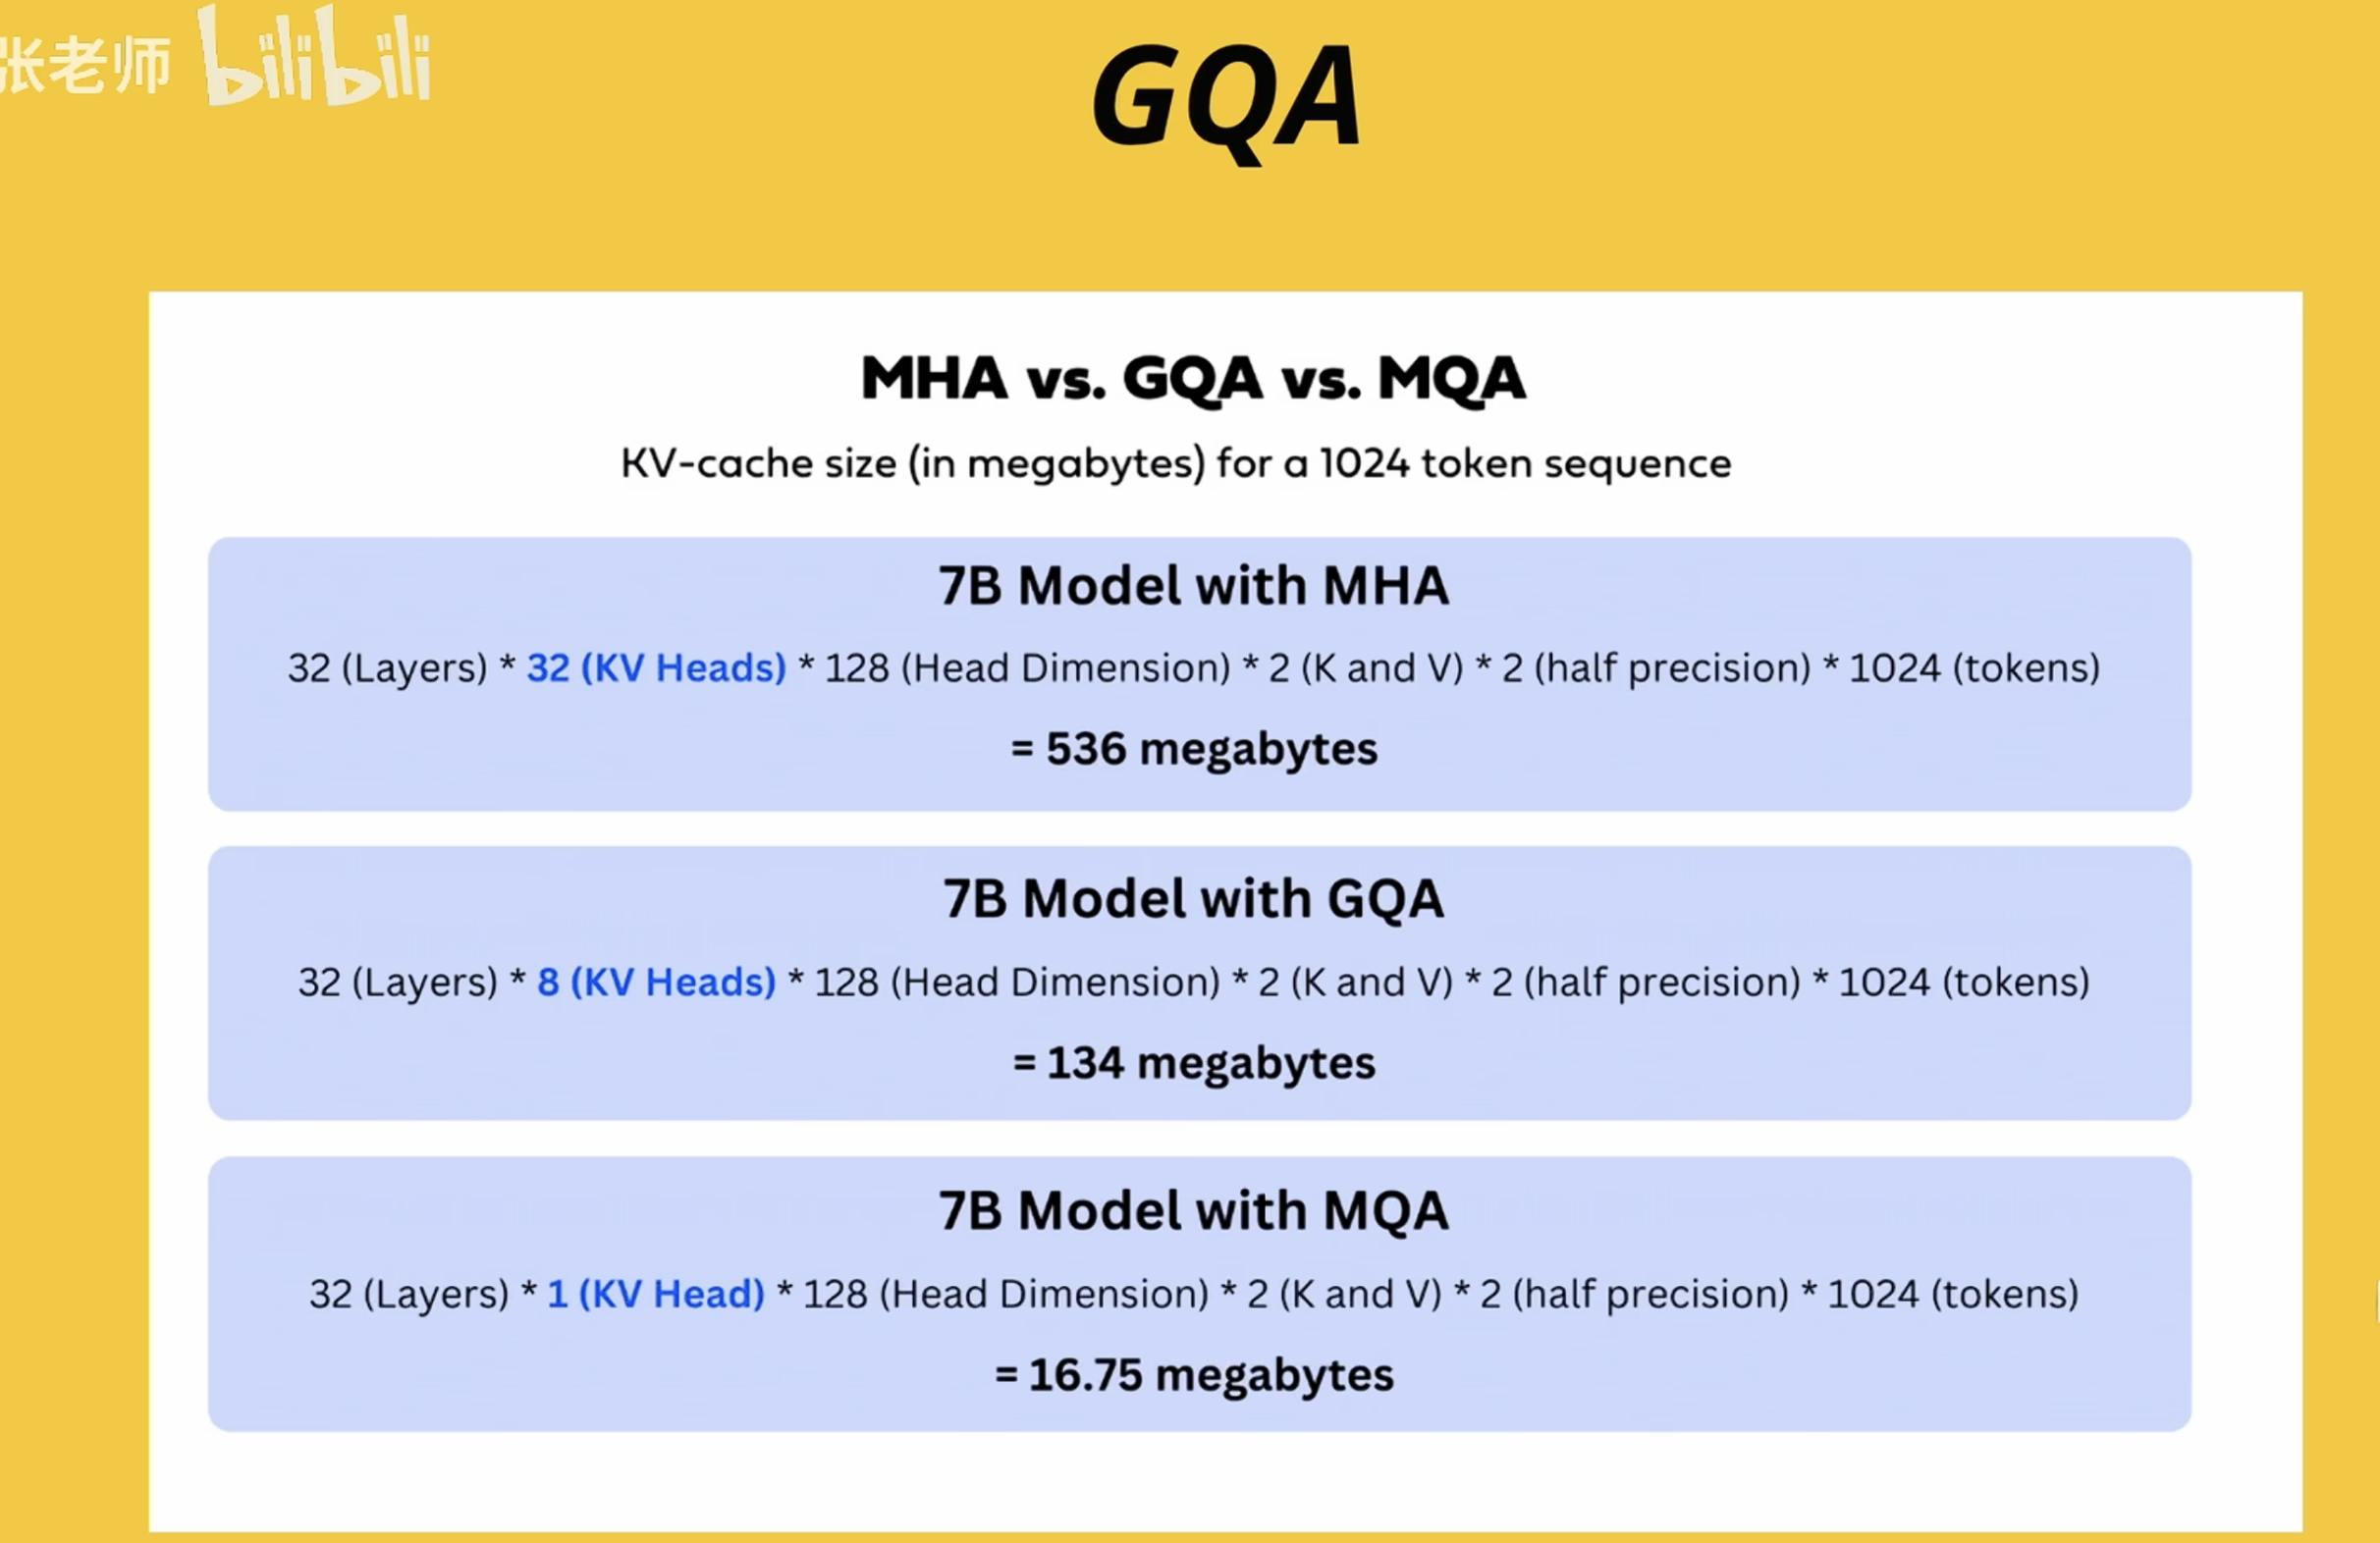

**总结**
- MQA参数量最少，但是保存的信息太少
- MHA保存的信息最多，但是显存消耗巨大
- 一般采用GQA的方法